# ML exercise to classify cats and dogs images

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import collections
import numpy as np

from src.ml import ImageFeatureExtractor, SKLinearImageModel
from src.directory_parser import DirectoryParser

Can't find GPU. TF will be work on CPU


DirectoryParser processes the input directory and collects full paths to the supported image files.

In [2]:
input_directory = 'data/demo'
dir_parser = DirectoryParser(input_directory)
print(dir_parser)

Found 24 jpg/png file(s) out of 25 file(s).
Unsupported files: {'1.txt'}


## Extract features

Transform images to the same small size (150, 150) and store them as numpy arrays

In [8]:
import os
from skimage.io import imread
from skimage.transform import resize

IMAGE_SIZE = (150, 150)
img_data = collections.defaultdict(list)

for filepath in dir_parser.full_path_image_files:
    label = os.path.split(filepath)[-1][:3]
    img_data['label'].append(label)
    
    im = imread(filepath)
    im = resize(im, IMAGE_SIZE)
    img_data['data'].append(im)
    
X = np.array(img_data['data'])
y = np.array(img_data['label'])

Display some resized labeled images from demo folder

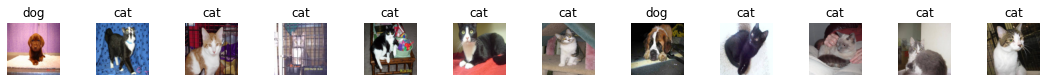

In [9]:
labels = y[:12]

fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15, 4)
fig.tight_layout()

for idx, (ax, label) in enumerate(zip(axes, labels)):
    ax.imshow(img_data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

## Data preprocessing

A classic approach to feature reduction for object recognition id HOG, which stands for Histogram of Oriented Gradients. HOG transformation lowers the complexity of the problem, while maintains as much variation as possible.

To calculate a HOG, an image is divided into blocks, for example 8 by 8 pixels. For each of these blocks, the magnitude of the gradient in a given number of directions is calculated. For a detailed explanation, refer to http://www.learnopencv.com/histogram-of-oriented-gradients/.

Here is an example.

Text(0.5, 1.0, 'hog')

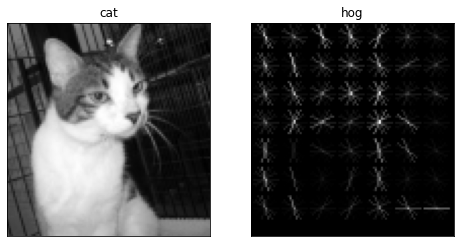

In [14]:
from skimage.feature import hog
from skimage.transform import rescale

cat = imread('data/demo/cat.783.jpg', as_gray=True)

# scale down the image to one third
cat = rescale(cat, 1/3, mode='reflect')
# calculate the hog and return a visual representation
cat_hog, cat_hog_img = hog(
    cat, pixels_per_cell=(14, 14),
    cells_per_block=(2, 2),
    orientations=9,
    visualize=True,
    block_norm='L2-Hys'
)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 6)
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]

ax[0].imshow(cat, cmap='gray')
ax[0].set_title('cat')
ax[1].imshow(cat_hog_img, cmap='gray')
ax[1].set_title('hog')

To perform the data preprocessing, use src.ml.image_transformers as follows:

In [15]:
from src.ml.sklearn_utils import HogTransformer, RGB2GrayTransformer

grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    None,
    pixels_per_cell=(8, 8),
    cells_per_block=(3, 3),
    orientations=9,
    block_norm='L2-Hys'
)

X_gray = grayify.fit_transform(X)
X_hog = hogify.fit_transform(X_gray)

## Train the model

In [16]:
from src.ml.feature_extractor import ImageFeatureExtractor
from src.ml.sklearn_model import SKLinearImageModel

BATCH_SIZE = 1000

dir_parser = DirectoryParser('data/train')
print(dir_parser)

# Feature extractor is responsible for converting images to numpy arrays
# and splitting the dataset into Train, Test
feature_extractor = ImageFeatureExtractor()

batches = feature_extractor.transform_image_to_dataset(dir_parser.full_path_image_files,
                                                       batch_size=BATCH_SIZE)
X_train, y_train, X_test, y_test = feature_extractor.combine_batches(batches=batches)

# None pkl_file means the model is not loaded but is trained from scratch.
model = SKLinearImageModel(pkl_file=None)

model.train(X_train, y_train, X_test, y_test)

# It is possible to save traned model, if the accuracy is decent.
# Saved model can be loaded and used for prediction on the unseen dataset.
# model.save(pkl_file='hog_model.pkl')

Found 414 jpg/png file(s) out of 414 file(s).
Unsupported files: 0
X shape (414, 150, 150, 3)
y shape (414,)
Train dataset shape (331, 150, 150, 3)
Test dataset shape (83, 150, 150, 3)
Labels ['cat' 'dog']


/home/dashaa/Work/cats_dogs/venv/lib/python3.7/site-packages/sklearn/utils/__init__.py:179: PerformanceWarning: Slicing with an out-of-order index is generating 84 times more chunks
  return array[key] if axis == 0 else array[:, key]
/home/dashaa/Work/cats_dogs/venv/lib/python3.7/site-packages/sklearn/utils/__init__.py:179: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks
  return array[key] if axis == 0 else array[:, key]


Accuracy: 0.65
              precision    recall  f1-score   support

         cat       0.82      0.64      0.72        58
         dog       0.45      0.68      0.54        25

    accuracy                           0.65        83
   macro avg       0.63      0.66      0.63        83
weighted avg       0.71      0.65      0.66        83



## Make predictions

Load from Pickle SKLinearImageModel which was trained on Kaggle dataset at https://www.kaggle.com/c/dogs-vs-cats/

In [17]:
dir_parser = DirectoryParser('data/demo')
print(f"Data dir: {dir_parser}")

Data dir: Found 24 jpg/png file(s) out of 25 file(s).
Unsupported files: {'1.txt'}


In [18]:
feature_extractor = ImageFeatureExtractor()
model = SKLinearImageModel(pkl_file='trained_models/hog_sklearn.pkl')
X, _ = feature_extractor.transform_image_to_dataset(dir_parser.full_path_image_files)[0]

In [19]:
X_prepared = model._preprocess_dataset(X, need_scale=False)
prediction = model.classifier.predict_proba(X_prepared)
y_proba_list = [model._predict_proba_to_label(proba) for proba in prediction]

In [20]:
for filepath, prediction in zip(dir_parser.full_path_image_files, y_proba_list):
    print(f'{filepath}: {prediction.value}')

data/demo/dog.2581.jpg: cat
data/demo/cat.798.jpg: unknown
data/demo/cat.797.jpg: cat
data/demo/cat.782.jpg: dog
data/demo/cat.799.jpg: cat
data/demo/cat.800.jpg: cat
data/demo/cat.789.jpg: cat
data/demo/dog.2580.jpg: dog
data/demo/cat.780.jpg: cat
data/demo/cat.790.jpg: cat
data/demo/cat.794.jpg: cat
data/demo/cat.783.jpg: cat
data/demo/cat.791.jpg: cat
data/demo/cat.796.jpg: cat
data/demo/cat.788.jpg: cat
data/demo/cat.785.jpg: cat
data/demo/cat.786.jpg: cat
data/demo/cat.787.jpg: cat
data/demo/cat.793.jpg: cat
data/demo/cat.795.jpg: cat
data/demo/cat.784.jpg: cat
data/demo/dog.2582.jpg: dog
data/demo/cat.792.jpg: cat
data/demo/cat.781.jpg: unknown
